In [1]:
import networkx as nx

In [2]:
#substrate graph 

In [3]:
Gs = nx.Graph()
Gs.add_nodes_from([1,2,3,4,5,6],cpu=20,st=20)
Gs.nodes[3]['st']=17
Gs.nodes[4]['st']=16
Gs.nodes[5]['st']=15
#add edges
Gs.add_edges_from([(1, 2),(1,6),(2,3),(2,5),(3,4),(4,5),(5,6)], weight=20 )

{(1, 2): Text(0.7499999888241293, 0.433012741974907, '20'),
 (1, 6): Text(0.7499999590218074, -0.43301269296576733, '20'),
 (2, 3): Text(-2.9802321943606103e-08, 0.8660254296429223, '20'),
 (2, 5): Text(4.4703482915409154e-08, 2.4504569873240456e-08, '20'),
 (3, 4): Text(-0.7500000037252903, 0.43301266846119746, '20'),
 (4, 5): Text(-0.7499999292194854, -0.43301273667715495, '20'),
 (5, 6): Text(1.4901160971803051e-08, -0.8660254104361045, '20')}

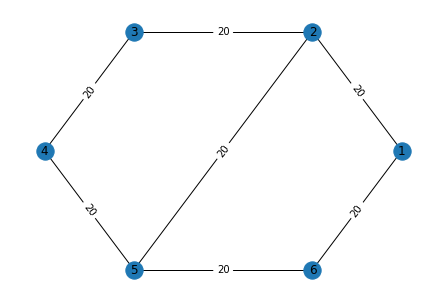

In [4]:
#nx.draw(Gs, with_labels=True, font_weight='bold')
#pos = nx.spring_layout(Gs, k=20)  # For better example looking
pos = nx.circular_layout(Gs, scale=1, center=None, dim=2)
nx.draw(Gs, pos, with_labels=True)
labels = {e: Gs.edges[e]['weight'] for e in Gs.edges}
nx.draw_networkx_edge_labels(Gs, pos, edge_labels=labels)

In [5]:
#request graph

In [6]:
Gv = nx.Graph()
Gv.add_node(1,cpu=5,st=5)
Gv.add_node(2,cpu=4,st=4)
Gv.add_node(3,cpu=3,st=3)
#add edges
Gv.add_edges_from([(1,2),(2,3),(3,1)],weight=2)

{(1, 2): Text(0.7499999888241293, 0.433012741974907, '2'),
 (1, 3): Text(0.24999998137354879, 0.4330127121725851, '2'),
 (2, 3): Text(-2.9802321943606103e-08, 0.8660254296429223, '2')}

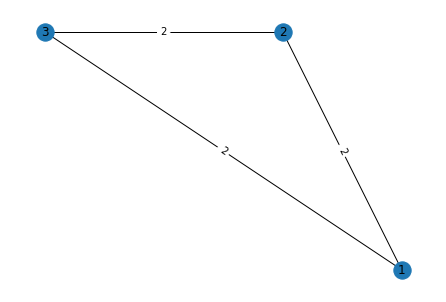

In [7]:
#pos = nx.spring_layout(Gs, k=20)  # For better example looking
pos = nx.circular_layout(Gs, scale=1, center=None, dim=2)
nx.draw(Gv, pos, with_labels=True)
labels = {e: Gv.edges[e]['weight'] for e in Gv.edges}
nx.draw_networkx_edge_labels(Gv, pos, edge_labels=labels)

In [8]:
Gv2 = nx.Graph()
Gv2.add_node(1,cpu=9,st=9)
Gv2.add_node(2,cpu=7,st=7)
Gv2.add_node(3,cpu=8,st=8)
Gv2.add_node(4,cpu=10,st=10)
#add edges
Gv2.add_edges_from([(1,2),(2,3),(3,1),(3,4),(4,1)],weight=5)
Gv2[1][2]['weight']=6
Gv2[3][4]['weight']=2
print()

{(1, 2): Text(0.7499999888241293, 0.433012741974907, '6'),
 (1, 3): Text(0.24999998137354879, 0.4330127121725851, '5'),
 (1, 4): Text(1.4901160971803051e-08, -1.9206817775722963e-08, '5'),
 (2, 3): Text(-2.9802321943606103e-08, 0.8660254296429223, '5'),
 (3, 4): Text(-0.7500000037252903, 0.43301266846119746, '2')}

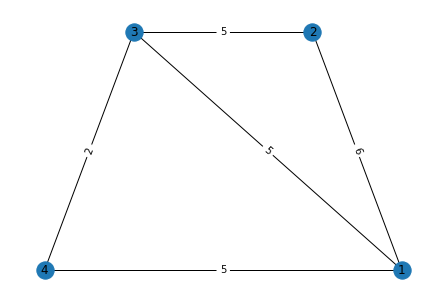

In [9]:
#pos = nx.spring_layout(Gv2, k=20)  # For better example looking
pos = nx.circular_layout(Gs, scale=1, center=None, dim=2)
nx.draw(Gv2, pos, with_labels=True)
labels = {e: Gv2.edges[e]['weight'] for e in Gv2.edges}
nx.draw_networkx_edge_labels(Gv2, pos, edge_labels=labels)

In [10]:
GVs = [Gv,Gv2]

In [11]:
#RCR ratio
def RCR(network):
    temp = []
    for node in network.nodes(data=True):
        rcr = node[1]['cpu']/node[1]['st']
        temp.append((rcr,node[0]))
    return sorted(temp,reverse=True)

In [12]:
#Node Rank Metric
def NRM(network):
    temp = []
    for node in network.nodes(data=True):
        sum_edge = 0
        for edge in network.edges(node[0],data=True):
            sum_edge = sum_edge + edge[2]['weight']
        met = (node[1]['cpu']+node[1]['st'])*(sum_edge)
        temp.append((met,node[0]))
    return sorted(temp,reverse=True)

In [13]:
def node_ranking(fGv):
    rcr_s = RCR(Gs)
    met_v = NRM(fGv)
    mapped = []
    mapping = []
    for node_v in met_v:
        n = fGv.nodes[node_v[1]]
        rcr_v = n['cpu']/n['st']
        diff = 10000 
        nv = -1 #virtual_node_num
        ns = -1 #substrate_node_num
        for node in rcr_s:
            if (node[1] not in mapped) and diff>(abs(rcr_v - node[0])) and Gs.nodes(data=True)[node[1]]['cpu']>=fGv.nodes(data=True)[node_v[1]]['cpu'] and Gs.nodes(data=True)[node[1]]['st']>=fGv.nodes(data=True)[node_v[1]]['st']:
                diff = abs(rcr_v - node[0]) #finding node with minimum difference in RCR of virtual node and substrate node
                ns = node[1]
                nv = node_v[1]
        if(ns == -1):
            return False, mapping
        
        mapped.append(ns)
        mapping.append({'Nv':nv,'Ns':ns})
    if(len(met_v)==len(mapped)):
        return True, mapping
    return False, mapping

In [14]:
def link_mapping(Vmap,fGv):
    edges=sorted(fGv.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
    mapping = []
    name_indexer = dict((p['Nv'], i) for i, p in enumerate(Vmap))
    for edge in edges:
        n1 = Vmap[name_indexer.get(edge[0])]['Ns']
        n2 = Vmap[name_indexer.get(edge[1])]['Ns']
        flag = 0
        rmv = []
        for e in list(Gs.edges(data=True)):
            print('-----------------')
            print(edge)
            print(e)
            print('-----------------')
            if e[2]['weight']<edge[2]['weight']:
                rmv.append(e)
                Gs.remove_edge(e[0],e[1])
        path = []
        #Find the shortest path
        if(nx.has_path(Gs,n1,n2)):
            path = nx.dijkstra_path(Gs,n1,n2,weight = 'weight')
        
        #Add the removed edges
        for ix in rmv:
            Gs.add_edge(ix[0],ix[1],weight=ix[2])
            
        if(len(path)==0):
            return False, []
        
        mapping.append([edge,path])
    
    for p in mapping: 
        for i in range(1,len(p[1])):
            Gs[p[1][i-1]][p[1][i]]['weight'] = Gs[p[1][i-1]][p[1][i]]['weight'] - p[0][2]['weight']
    return True, mapping

In [15]:
def RCR_VNE(Gvs):
    rejected = 0
    accepted = 0
    count = 1
    for NRM_Gv in Gvs:
        print('Vnet_'+str(count)+':')
        flag, Vmap = node_ranking(NRM_Gv)
        if(not flag):
            print('Not mapped')
            rejected = rejected + 1
            continue
        flag, Emap = link_mapping(Vmap,NRM_Gv)
        if(not flag):
            print('Not mapped')
            rejected = rejected + 1
            continue
        accepted = accepted +1
        #updating the Substrate graph CPU and Storage
        for node in Vmap:
            Gs.nodes(data=True)[node['Ns']]['cpu'] = Gs.nodes(data=True)[node['Ns']]['cpu'] - NRM_Gv.nodes(data=True)[node['Nv']]['cpu']
            Gs.nodes(data=True)[node['Ns']]['st'] = Gs.nodes(data=True)[node['Ns']]['st'] - NRM_Gv.nodes(data=True)[node['Nv']]['st']
        
        print(Vmap)
        print(Emap)
        count = count+1
    print('Acceptance Ratio:' + str(accepted/len(Gvs)))

In [16]:
RCR_VNE(GVs)

Vnet_1:
-----------------
(1, 2, {'weight': 2})
(1, 2, {'weight': 20})
-----------------
-----------------
(1, 2, {'weight': 2})
(1, 6, {'weight': 20})
-----------------
-----------------
(1, 2, {'weight': 2})
(2, 3, {'weight': 20})
-----------------
-----------------
(1, 2, {'weight': 2})
(2, 5, {'weight': 20})
-----------------
-----------------
(1, 2, {'weight': 2})
(3, 4, {'weight': 20})
-----------------
-----------------
(1, 2, {'weight': 2})
(4, 5, {'weight': 20})
-----------------
-----------------
(1, 2, {'weight': 2})
(5, 6, {'weight': 20})
-----------------
-----------------
(1, 3, {'weight': 2})
(1, 2, {'weight': 20})
-----------------
-----------------
(1, 3, {'weight': 2})
(1, 6, {'weight': 20})
-----------------
-----------------
(1, 3, {'weight': 2})
(2, 3, {'weight': 20})
-----------------
-----------------
(1, 3, {'weight': 2})
(2, 5, {'weight': 20})
-----------------
-----------------
(1, 3, {'weight': 2})
(3, 4, {'weight': 20})
-----------------
-----------------
(1

{(1, 2): Text(0.7499999888241293, 0.433012741974907, '1'),
 (1, 6): Text(0.7499999590218074, -0.43301269296576733, '0'),
 (2, 3): Text(-2.9802321943606103e-08, 0.8660254296429223, '13'),
 (2, 5): Text(4.4703482915409154e-08, 2.4504569873240456e-08, '20'),
 (3, 4): Text(-0.7500000037252903, 0.43301266846119746, '20'),
 (4, 5): Text(-0.7499999292194854, -0.43301273667715495, '20'),
 (5, 6): Text(1.4901160971803051e-08, -0.8660254104361045, '20')}

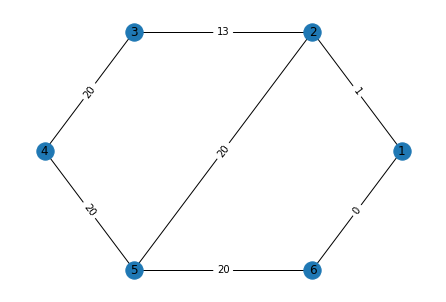

In [17]:
#pos = nx.spring_layout(Gs, k=20)  # For better example looking
pos = nx.circular_layout(Gs, scale=1, center=None, dim=2)
nx.draw(Gs, pos, with_labels=True)
labels = {e: Gs.edges[e]['weight'] for e in Gs.edges}
nx.draw_networkx_edge_labels(Gs, pos, edge_labels=labels)

In [18]:
Gs.nodes(data=True)

NodeDataView({1: {'cpu': 10, 'st': 10}, 2: {'cpu': 8, 'st': 8}, 3: {'cpu': 10, 'st': 7}, 4: {'cpu': 20, 'st': 16}, 5: {'cpu': 20, 'st': 15}, 6: {'cpu': 6, 'st': 6}})

In [19]:
Gs.edges(data=True)

EdgeDataView([(1, 2, {'weight': 1}), (1, 6, {'weight': 0}), (2, 3, {'weight': 13}), (2, 5, {'weight': 20}), (3, 4, {'weight': 20}), (4, 5, {'weight': 20}), (5, 6, {'weight': 20})])